**MACHINE LEARNING FOR EARTH OBSERVATION - Land cover semantic segmentation - Landcover.ai
dataset**

This project involves implementing a convolutional neural network (CNN) to perform semantic segmentation on the LandCover.ai dataset. This dataset includes images labeled into categories such as buildings, woodlands, water bodies, roads, and other backgrounds. The goal was to classify each pixel of the image into these categories, which are crucial for environmental monitoring and urban planning.

Tasks Accomplished:

- Preprocessing images and masks into a uniform size.
- Splitting the data into training, validation, and testing sets.
- Developing a CNN model under the constraint of 35 million parameters.
- Training the model with real-time performance monitoring using tools like wandb.
- Evaluating the model on a test set and visualizing predictions against ground truth

In [1]:
#load the data
import zipfile
!wget -O landcover.zip https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip


--2024-04-03 11:59:57--  https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip
Resolving landcover.ai.linuxpolska.com (landcover.ai.linuxpolska.com)... 195.78.67.65
Connecting to landcover.ai.linuxpolska.com (landcover.ai.linuxpolska.com)|195.78.67.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1538212277 (1.4G) [application/zip]
Saving to: 'landcover.zip'

landcover.zip       100%[===================>]   1.43G  9.89MB/s    in 2m 16s  

2024-04-03 12:02:15 (10.8 MB/s) - 'landcover.zip' saved [1538212277/1538212277]



In [2]:
#unzip the data zip file
!unzip landcover.zip -d /kaggle/working/

Archive:  landcover.zip
   creating: /kaggle/working/images/
  inflating: /kaggle/working/images/M-33-48-A-c-4-4.tif  
  inflating: /kaggle/working/images/M-33-20-D-c-4-2.tif  
  inflating: /kaggle/working/images/M-33-20-D-d-3-3.tif  
  inflating: /kaggle/working/images/M-33-32-B-b-4-4.tif  
  inflating: /kaggle/working/images/M-33-7-A-d-2-3.tif  
  inflating: /kaggle/working/images/M-33-7-A-d-3-2.tif  
  inflating: /kaggle/working/images/M-34-32-B-a-4-3.tif  
  inflating: /kaggle/working/images/M-34-32-B-b-1-3.tif  
  inflating: /kaggle/working/images/M-34-5-D-d-4-2.tif  
  inflating: /kaggle/working/images/M-34-51-C-b-2-1.tif  
  inflating: /kaggle/working/images/M-34-51-C-d-4-1.tif  
  inflating: /kaggle/working/images/M-34-55-B-b-4-1.tif  
  inflating: /kaggle/working/images/M-34-56-A-b-1-4.tif  
  inflating: /kaggle/working/images/M-34-6-A-d-2-2.tif  
  inflating: /kaggle/working/images/M-34-65-D-a-4-4.tif  
  inflating: /kaggle/working/images/M-34-65-D-c-4-2.tif  
  inflating: /k

In [3]:
#Run the zip file
!python split.py

Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A-c-1-3 31/41
Processed N-

In [4]:
#Import all necessary packages
import rasterio as rio
from rasterio.merge import merge
import numpy as np
from glob import glob
import os
import shutil
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
from matplotlib import pyplot as plt
from PIL import Image

#MASK TRANSFORMATIONS
from torchvision.transforms.functional import to_pil_image, resize
import rasterio
from rasterio import windows

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", DEVICE)

Device: cuda


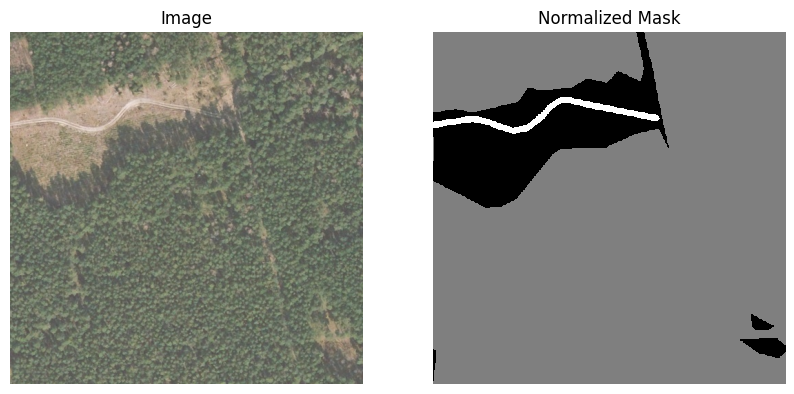

In [6]:


# Read the image
image_path = cv2.imread('/kaggle/working/output/N-34-97-D-c-2-4_79.jpg')
mask  = Image.open ('/kaggle/working/output/N-34-97-D-c-2-4_79_m.png')
mask = np.array(mask)
# Convert BGR image to RGB for correct coloring
image_path_rgb = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)

class_to_grayscale = {
    0: 0,   # Background to black
    2: 127, # Class 2 to mid-gray
    4: 255  # Class 4 to white
}

# Normalize mask by mapping class values to the grayscale range
normalized_mask = np.vectorize(class_to_grayscale.get)(mask)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the original mask
axs[0].imshow(image_path_rgb)  
axs[0].set_title('Image')
axs[0].axis('off')  # Hide the axis on the first plot

# Plot the normalized mask
# Normalized mask in grayscale
axs[1].imshow(normalized_mask, cmap='gray', interpolation='nearest')  
axs[1].set_title('Normalized Mask')
axs[1].axis('off')  # Hide the axis on the second plot
plt.axis('off') # Hide the axis
plt.show()


# # Display the image
# plt.imshow(image_path_rgb)
# plt.axis('off') # Hide the axis
# plt.show()


In [7]:

# Function to read image names from a text file and create a dataframe
def create_dataframe_from_txt(file_path, folder_path):
    # Read the text file lines into a list
    with open(file_path, 'r') as file:
        image_names = file.read().splitlines()
    
    # Create a dataframe with image paths and mask paths
    data = {
        'image': [f"{folder_path}/{name}.jpg" for name in image_names],
        'mask': [f"{folder_path}/{name}_m.png" for name in image_names]
    }
    df = pd.DataFrame(data)
    
    return df


folder_path = '/kaggle/working/output'

# File paths to train, validation, and test sets text files
train_file_path = '/kaggle/working/train.txt'
val_file_path = '/kaggle/working/val.txt'
test_file_path = '/kaggle/working/test.txt'

# Create dataframes for train, validation, and test sets
train_df = create_dataframe_from_txt(train_file_path, folder_path)
val_df = create_dataframe_from_txt(val_file_path, folder_path)
test_df = create_dataframe_from_txt(test_file_path, folder_path)


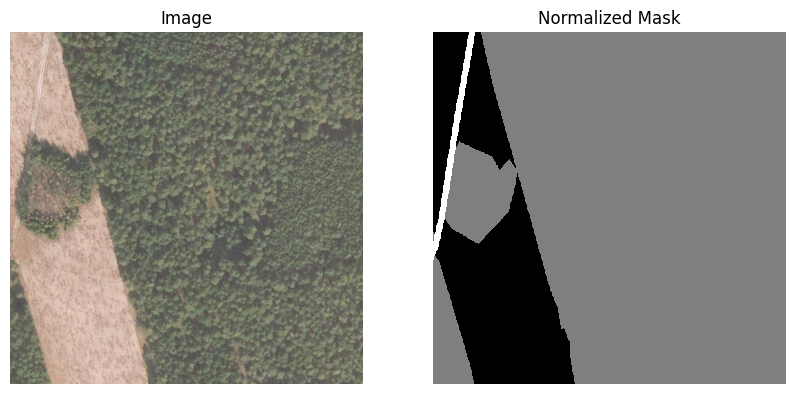

In [8]:

# Read the image
image_path = cv2.imread('/kaggle/working/output/N-34-97-D-c-2-4_73.jpg')
mask  = Image.open ('/kaggle/working/output/N-34-97-D-c-2-4_73_m.png')
mask = np.array(mask)
# Convert BGR image to RGB for correct coloring
image_path_rgb = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)

class_to_grayscale = {
    0: 0,   # Background to black
    2: 127, # Class 2 to mid-gray
    4: 255  # Class 4 to white
}

# Normalize mask by mapping class values to the grayscale range
normalized_mask = np.vectorize(class_to_grayscale.get)(mask)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the original mask
axs[0].imshow(image_path_rgb)  
axs[0].set_title('Image')
axs[0].axis('off')  # Hide the axis on the first plot

# Plot the normalized mask
# Normalized mask in grayscale
axs[1].imshow(normalized_mask, cmap='gray', interpolation='nearest')  
axs[1].set_title('Normalized Mask')
axs[1].axis('off')  # Hide the axis on the second plot
plt.axis('off') # Hide the axis
plt.show()


# # Display the image
# plt.imshow(image_path_rgb)
# plt.axis('off') # Hide the axis
# plt.show()


In [9]:

# def custom_one_hot_encoding(mask, num_classes=5):
#     # Initialize a zero tensor with shape [num_classes, H, W]
#     one_hot = torch.zeros((num_classes, *mask.shape), dtype=torch.float32)
#     for i in range(num_classes):
#         # Here, explicitly set each class channel based on the class index
#         one_hot[i] = (mask == i).float()
#     return one_hot

class ImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, mask_transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing paths to the images and masks.
            image_transform (callable, optional): Optional transform to be applied on the images.
            mask_transform (callable, optional): Optional transform to be applied on the masks.
        """
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image and mask paths from dataframe
        image_path = self.dataframe.iloc[idx, 0]
        mask_path = self.dataframe.iloc[idx, 1]
        
        # Open and convert images and masks
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale to represent class indices
        #print(np.unique(mask))
        #print(f' Original mask values before transformations................ {np.unique(mask)}')
        
        
        # Apply transformations if any
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            #print(f' Masks after transormations,,,,,,,,,,,,,,,,,,,,,,,,,, {np.unique(mask)}')
        else:
            # Convert PIL image to numpy array
            mask = np.array(mask, dtype=np.int64)  # Ensure int64 for class indices
        
        # Convert numpy array to a PyTorch tensor
        if not torch.is_tensor(mask):
            mask_tensor = torch.tensor(mask, dtype=torch.int64)
        else:
            mask_tensor = mask.long()
            
        #print(f' Masks Tensors before one hot encoding.............. {np.unique(mask_tensor)}')

        # Apply custom one-hot encoding
        #one_hot_mask = custom_one_hot_encoding(mask_tensor, num_classes=5)

        return image,mask_tensor


In [10]:
def transform_mask(mask, size=(512, 512), interpolation=Image.NEAREST):
    # Resize mask using PIL's NEAREST interpolation to avoid altering class indices
    mask = resize(mask, size, interpolation=interpolation)
    # Convert mask to numpy array without normalization
    mask = np.array(mask, dtype=np.int64)
    return mask

In [11]:

# Image Transformations
image_transforms = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


# Create dataset objects
train_dataset = ImageMaskDataset(train_df, image_transform=image_transforms,mask_transform = transform_mask)
train_dloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = ImageMaskDataset(val_df, image_transform=image_transforms,mask_transform = transform_mask)
val_dloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

test_dataset = ImageMaskDataset(test_df, image_transform=image_transforms,mask_transform= transform_mask)
test_dloader = DataLoader(test_dataset, batch_size=4, shuffle=False)



In [12]:
#CHECKING MASK AND IMAGE DIMENSION, MASK PIXEL VALUE RANGE

# Fetch a batch from the DataLoader
dataiter = iter(train_dloader)
images, masks = dataiter.__next__()

# images and masks are now tensors
print("Images shape:", images.shape)  
print("Masks shape:", masks.shape)  

# To view the actual mask values for the first image in the batch:
print("Mask values for the first image in the batch:", np.unique(masks[2]))

Images shape: torch.Size([4, 3, 512, 512])
Masks shape: torch.Size([4, 512, 512])
Mask values for the first image in the batch: [0 2]


**CNN ARCHITECTURE - UNET 8 WITH PRETRAINED ENCODER AND CUSTOM DECODER**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision.models import resnet18, ResNet18_Weights

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.upconv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super(UNet, self).__init__()
        #self.encoder = resnet18(pretrained=True)
        self.encoder = resnet18(weights=ResNet18_Weights.DEFAULT)

        self.encoder_layers = list(self.encoder.children())

        # Encoder
        self.conv1 = nn.Sequential(*self.encoder_layers[:3])
        self.conv2 = nn.Sequential(*self.encoder_layers[3:5])
        self.conv3 = self.encoder_layers[5]
        self.conv4 = self.encoder_layers[6]
        self.conv5 = self.encoder_layers[7]

        # Decoder
        self.upconv1 = UpConvBlock(512, 256) # Corresponding to the output size of conv4
        self.upconv2 = UpConvBlock(256, 128) # Corresponding to the output size of conv3
        self.upconv3 = UpConvBlock(128, 64) # Corresponding to the output size of conv2
        self.upconv4 = UpConvBlock(64, 64) # Corresponding to the output size of conv1

        # Final convolution to adjust output size to 512x512
        self.final_conv = nn.ConvTranspose2d(64, n_classes, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv4_out)

        # Decoder
        upconv1_out = self.upconv1(conv5_out)
        upconv2_out = self.upconv2(upconv1_out)
        upconv3_out = self.upconv3(upconv2_out)
        upconv4_out = self.upconv4(upconv3_out)

        # Final convolution
        final_out = self.final_conv(upconv4_out)

        return final_out


In [14]:
#creating an instance of the model architecture 

# # Instantiate the model
# #model = ResNetUNet(n_classes=5).to(DEVICE)
# # Example usage
# model = UNet(n_classes=5)

model = UNet(n_classes=5).to(DEVICE)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [15]:
def count_parameters(model):
    """
    Count the total number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): PyTorch model for parameter counting.

    Returns:
        None: Prints the total number of trainable parameters in the model.
    """
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'Model total parameters: {sum(params):>6}')

In [16]:
# Total number of parameters in the model
count_parameters(model)

Model total parameters: 12395821


**Model Training**

In [17]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # For optimer and loss function
# import torch.optim as optim
epochs = 10

# optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
# #scheduler =optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)
# #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_dloader) * epochs))
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=3, verbose=False)


In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Scheduler (optional, choose one)
#scheduler_step = StepLR(optimizer, step_size=30, gamma=0.1)  # Example: Decay LR every 30 epochs
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.85, patience=3)  


In [19]:
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
#train funcction 
def train(model, dataloader, optimizer, criterion, device=DEVICE):
    model.train()
    total_loss = 0
    f1=0.0
    acc=0.0
    
    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=100)

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
      
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)  # Convert softmax output to class indices
        
        # Flatten labels and predictions to calculate metrics
        true_labels = labels.cpu().numpy().flatten()
        predicted_labels= preds.cpu().numpy().flatten()
        
        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))))
       
        f1 += f1_score(true_labels, predicted_labels, average='macro')
        acc += accuracy_score(true_labels, predicted_labels)
        batch_bar.update()

    batch_bar.close()

#
    f1score =   f1/len(dataloader)
    accuracy = acc/len(dataloader)
    avg_loss = total_loss / len(dataloader)
#     print(f'Done with computation {accuracy}')

    return accuracy,f1score,  avg_loss


In [20]:
#validation function
from sklearn.metrics import f1_score, accuracy_score
import torch
from tqdm import tqdm

def validate(model, dataloader, criterion, device=DEVICE):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    f1 = 0.0
    acc = 0.0
  
 
    with torch.no_grad():  # No need to compute gradient during validation
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)  # Convert softmax output to class indices
            true_labels = labels.cpu().numpy().flatten()
            predicted_labels = preds.cpu().numpy().flatten()
             
            f1 += f1_score(true_labels, predicted_labels, average='macro')
            acc += accuracy_score(true_labels, predicted_labels)


            # Optionally update batch_bar here

   

    f1score =   f1/len(dataloader)
    accuracy = acc/len(dataloader)
    avg_loss = total_loss / len(dataloader)

    return accuracy,f1score, avg_loss


In [21]:
#Training loop
best_f1score = 0.0 # Initialize the f1 score to help saving the best model
import torch.nn.functional as F
for epoch in range(epochs):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_f1score, train_loss = train(model, train_dloader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain ACC {}: \t Train f1 score  {:.04f}\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        epochs,
        train_acc,
        train_f1score,
        train_loss,
        curr_lr))

    val_acc, val_f1score, val_loss = validate(model, val_dloader, criterion, DEVICE)

    print("Val Acc  {:.04f}%\t Val f1 score  {:.04f}%\t Val Loss {:.04f}".format( val_acc, val_f1score, val_loss))

    # learning rate scheduler, update
    scheduler.step(val_loss)

    # Save the best model based on accuracy
    if val_f1score>= best_f1score:

        path = './best_model_part_1.pth'
        print("Saving model")
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_f1score': val_f1score,
                  'epoch': epoch}, path)
        best_f1score= val_f1score
        
    




Epoch 1/10: 
Train ACC 0.7455828552327779: 	 Train f1 score  0.3889	 Train Loss 0.7222	 Learning Rate 0.0010
Val Acc  0.8454%	 Val f1 score  0.4543%	 Val Loss 0.5002
Saving model



Epoch 2/10: 
Train ACC 0.8258450250809402: 	 Train f1 score  0.4406	 Train Loss 0.5144	 Learning Rate 0.0010
Val Acc  0.8020%	 Val f1 score  0.4163%	 Val Loss 0.5301



Epoch 3/10: 
Train ACC 0.8657337567535662: 	 Train f1 score  0.4779	 Train Loss 0.4004	 Learning Rate 0.0010
Val Acc  0.8883%	 Val f1 score  0.4940%	 Val Loss 0.3531
Saving model



Epoch 4/10: 
Train ACC 0.8692882653222094: 	 Train f1 score  0.4897	 Train Loss 0.3840	 Learning Rate 0.0010
Val Acc  0.8737%	 Val f1 score  0.4716%	 Val Loss 0.3510



Epoch 5/10: 
Train ACC 0.8845247512711192: 	 Train f1 score  0.5256	 Train Loss 0.3336	 Learning Rate 0.0010
Val Acc  0.8764%	 Val f1 score  0.5207%	 Val Loss 0.3336
Saving model



Epoch 6/10: 
Train ACC 0.8925235552246616: 	 Train f1 score  0.5609	 Train Loss 0.3095	 Learning Rate 0.0010
Val Acc  0.8953%	 Val f1 score  0.5255%	 Val Loss 0.2900
Saving model



Epoch 7/10: 
Train ACC 0.8988720824427472: 	 Train f1 score  0.5886	 Train Loss 0.2849	 Learning Rate 0.0010
Val Acc  0.9101%	 Val f1 score  0.5593%	 Val Loss 0.2766
Saving model



Epoch 8/10: 
Train ACC 0.9029235615209543: 	 Train f1 score  0.6014	 Train Loss 0.2767	 Learning Rate 0.0010
Val Acc  0.8907%	 Val f1 score  0.5997%	 Val Loss 0.2757
Saving model



Epoch 9/10: 
Train ACC 0.9074069473421803: 	 Train f1 score  0.6235	 Train Loss 0.2584	 Learning Rate 0.0010



Epoch 10/10: 
Train ACC 0.9092961006042023: 	 Train f1 score  0.6344	 Train Loss 0.2526	 Learning Rate 0.0010
Val Acc  0.9234%	 Val f1 score  0.6276%	 Val Loss 0.2147
Saving model


In [24]:

#load the best model
model.state_dict(torch.load('./best_model_part_1.pth'))
model.eval().to(DEVICE)

UNet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [25]:
#Function to evaluate the best model on test set

def evaluate_on_test_set(model, dataloader, criterion, device=DEVICE):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    f1 = 0.0
    acc = 0.0
    predicted_labels_list = []
    
  
 
    with torch.no_grad():  # No need to compute gradient during validation
        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)  # Convert softmax output to class indices
            true_labels = labels.cpu().numpy().flatten()
            predicted_labels = preds.cpu().numpy().flatten()
            predicted_labels_list.append(predicted_labels)
             
            f1 += f1_score(true_labels, predicted_labels, average='macro')
            acc += accuracy_score(true_labels, predicted_labels)




    f1score =   f1/len(dataloader)
    accuracy = acc/len(dataloader)
    avg_loss = total_loss / len(dataloader)


    return predicted_labels_list,accuracy,f1score, avg_loss


In [26]:
preds, accuracy, f1score, avg_loss = evaluate_on_test_set(model, test_dloader,criterion, device=DEVICE)

In [27]:
#valuate the trained model on the test set using both accuracy and F1-score and note thedifference
print(f'The model accuracy on the test set: {accuracy}')
print(f'The model f1 score  on the test set: {f1score}')


The model accuracy on the test set: 0.9200332218274808
The model f1 score  on the test set: 0.6197905051343082


**Making Predictions**

In [34]:
def infer_merge_masks(model, input_path, transform=None, batch_size = 32):
    """
    Infers segmentation masks using the provided model and merges them into a single image.

    Parameters:
    model (torch.nn.Module): The trained segmentation model.
    input_path (str): Path to the directory containing input tiles/images in tif format.
    transform (callable, optional): A function/transform to preprocess the input images. Default is None.
    batch_size (int, optional): Batch size for inference. Default is 32.

    Returns:
    None

    Raises:
    FileNotFoundError: If the input_path does not exist.
    """
    # Check if input_path exists
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input path '{input_path}' does not exist.")

    tile_names = glob(os.path.join(input_path,"*.tif"))
    num_images = len(tile_names)
    num_batches = int(np.ceil(num_images / batch_size))

    os.makedirs('./predictions', exist_ok=True)
    os.makedirs('./mask_merged', exist_ok=True) 

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(batch_start + batch_size, num_images)
        batch_tile_names = tile_names[batch_start:batch_end]

        batch_images = []
        batch_mask_names = []
        for image in batch_tile_names:
            mask_name = image.split('\\')[-1]
            image_ = cv2.imread(image)
            val_im = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image_ = Image.fromarray(val_im)
            if transform:
                val_im = transform(image_)

            batch_images.append(val_im.to(DEVICE))
            batch_mask_names.append(mask_name)

        batch_images = torch.stack(batch_images, dim=0)

        with torch.no_grad():
                pred_masks = model(batch_images)


        pred_masks = torch.argmax(pred_masks, dim=1).cpu().numpy()

        for idx, image in enumerate(batch_tile_names):
            mask_name = batch_mask_names[idx]
            pred_mask_ = pred_masks[idx]

            with rio.open(image) as tile:
                with rio.Env():
                    profile = tile.profile
                    profile.update(
                        dtype=rio.uint8,
                        count=1,
                        compress='lzw',
                        nodata=255)

                      
                    mask_name = os.path.basename(image)  # Gets the file name regardless of OS-specific path separator
                    prediction_path = os.path.join('./predictions', mask_name)  # Construct the path

                    # Use the constructed path for saving
                    with rio.open(prediction_path, 'w', **profile) as dst:
                        dst.write(pred_mask_.astype(rio.uint8), 1)
                    


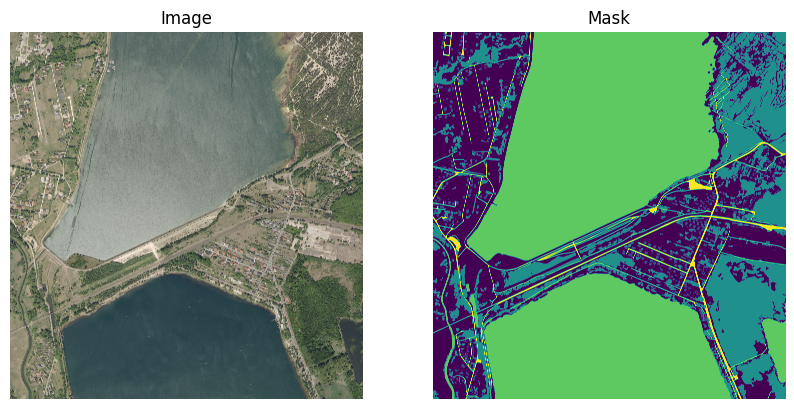

In [35]:
#PLot Image and its original mask

test_img = plt.imread('/kaggle/working/images/M-34-51-C-d-4-1.tif')
test_mask = plt.imread('/kaggle/working/masks/M-34-51-C-d-4-1.tif')


fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the original mask
axs[0].imshow(test_img)
axs[0].set_title('Image')
axs[0].axis('off')  # Hide the axis on the first plot

#visualize the mask

plt.imshow(test_mask)
axs[1].set_title('Mask')
axs[1].axis('off')  
plt.show()

In [36]:
#function to split the tif file 


def split_tif_into_tiles(tif_path, output_dir, target_size=512):
    """
    Split a TIFF file into smaller tiles of a specified size, preserving geospatial information.
    
    Args:
        tif_path (str): Path to the input TIFF file.
        output_dir (str): Directory where output tiles will be saved.
        target_size (int): The size of the side of the square tiles in pixels.
    """
    with rasterio.open(tif_path) as dataset:
        # Calculate the number of tiles in each dimension
        n_tiles_x = dataset.width // target_size
        n_tiles_y = dataset.height // target_size
        
        # Create the output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Tile index for naming
        tile_index = 0
        
        for i in range(n_tiles_x):
            for j in range(n_tiles_y):
                # Calculate window bounds (left, bottom, right, top)
                window = windows.Window(i * target_size, j * target_size, target_size, target_size)
                
                # Read the data in the window
                data = dataset.read(window=window)
                
                # Define the transform for the tile
                transform = dataset.window_transform(window)
                
                # Define the metadata for the tile
                meta = dataset.meta.copy()
                meta.update({
                    "driver": "GTiff",
                    "height": window.height,
                    "width": window.width,
                    "transform": transform
                })
                
                # Save the tile
                tile_filename = os.path.join(output_dir, f"tile_{tile_index}.tif")
                with rasterio.open(tile_filename, "w", **meta) as dest:
                    dest.write(data)
                
                tile_index += 1
                
                #print(f"Tile {tile_index} saved to {tile_filename}")

# Function Usage
tif_path =  '/kaggle/working/images/M-34-51-C-d-4-1.tif' 
output_dir = "./tiles"
target_size = 512  

split_tif_into_tiles(tif_path, output_dir, target_size)


In [37]:
input_path = '/kaggle/working/tiles'

predicted_mask = infer_merge_masks(model, input_path, transform=image_transforms, batch_size = 4)

In [38]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os

def create_image_from_patches(patches_path, out_path):
    """
    Merge TIFF files from a directory into a single raster image.

    Args:
        patches_path (str): Path to the directory containing TIFF raster patches.
        out_path (str): Path where the merged raster image will be saved.
    """
    # Collect all TIFF files in the specified directory
    patches_names = glob.glob(os.path.join(patches_path, "*.tif"))
    
    # Check if we found any patches
    if not patches_names:
        raise FileNotFoundError(f"No TIFF files found in {patches_path}.")
    
    # Open all the raster files
    src_files_to_mosaic = []
    for patch in patches_names:
        src = rasterio.open(patch)
        src_files_to_mosaic.append(src)
    
    # Merge function returns a single mosaic array and the transformation info
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Copy the metadata of the first file
    out_meta = src_files_to_mosaic[0].meta.copy()
    
    # Update the metadata with new dimensions, transform, and CRS
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        
    })
    
    # Write the mosaic raster to disk
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Close all raster files
    for src in src_files_to_mosaic:
        src.close()
    
    print(f"Merged raster saved to {out_path}")

# Function Usage
patches_path = '/kaggle/working/predictions'  
out_path = '/kaggle/working/merged.tif'  
create_image_from_patches(patches_path, out_path)


Merged raster saved to /kaggle/working/merged.tif


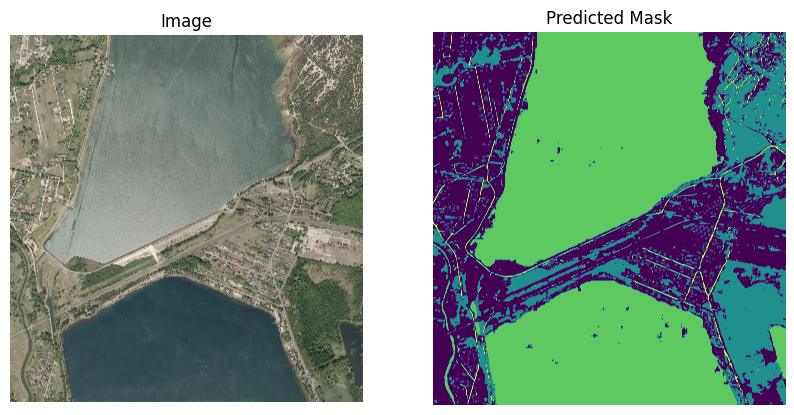

In [39]:

#PLot Image and its predicted mask
test_img = plt.imread('/kaggle/working/images/M-34-51-C-d-4-1.tif')
predicted_mask = plt.imread('/kaggle/working/merged.tif')


fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the original mask
axs[0].imshow(test_img)
axs[0].set_title('Image')
axs[0].axis('off')  # Hide the axis on the first plot

#visualize the mask

plt.imshow(predicted_mask )
axs[1].set_title('Predicted Mask')
axs[1].axis('off')  
plt.show()